In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# 13. Generative Adversarial Networks




## Lab 006

> 문제 12 - LeNet-5 구현하기
---

다음 CNN 아키텍처 그림을 참조하여 tensorflow 로 구현하시오.


<img src="https://drek4537l1klr.cloudfront.net/elgendy/v-3/Figures/05_01.png" width=800 />

Hint: 336p 코드를 참고하시오.

# 13.2 Upsampling


비전에서 사용하는 두 가지 종류의 업샘플링 방법이 있음

* Non-Learnable interpolation methods : nearest neighbor, bi-linear, bi-cubic 등)

* Learnable neural network methods : transposed convolution, fractionally-stride convolution

<설명>

* CNN에서 Pooling Layer 연산의 역연산이 필요





## 13.2.1 UpSampling2D & tf.image.resize()

* 업샘플링 레이어는 가중치가 없는 단순한 레이어

* 입력 크기를 두 배로 늘려 보자!

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 56, 56, 1)        0         
 )                                                               
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 166ms/step
img.shape= (8, 56, 56)


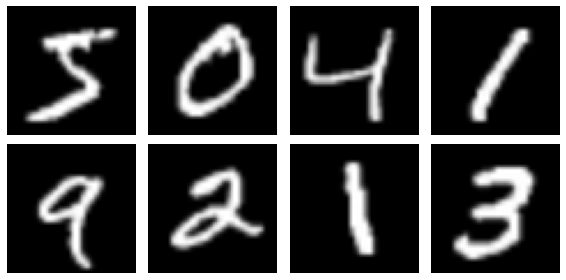

origin_img.shape= (8, 28, 28)


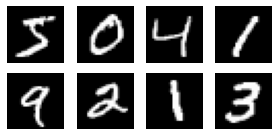

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#1: 
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train_origin, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_origin = x_train_origin.astype('float32')
x_test  = x_test.astype('float32')

# expand data with channel = 1
x_train = np.expand_dims(x_train_origin,axis = 3)      # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, axis = 3)      # (10000, 28, 28, 1)
 
#3: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(x_train.shape[1:])) # shape = (28, 28, 1)
model.add(tf.keras.layers.UpSampling2D(interpolation='bilinear')) # size =(2,2) 
model.summary()

#4: apply x_train to model
output = model.predict(x_train[:8])  # (8, 56, 56, 1)
img = output[:,:,:,0]                # 0-channel                  
print("img.shape=", img.shape)

#5: display images
fig = plt.figure(figsize = (8, 4))
for i in range(8):   
    plt.subplot(2, 4, i + 1)  
    plt.imshow(img[i], cmap = 'gray')
    plt.axis("off")
fig.tight_layout()
plt.show()

origin_img = x_train_origin[:8]
print("origin_img.shape=", origin_img.shape)

fig = plt.figure(figsize = (4, 2))
for i in range(8):   
    plt.subplot(2, 4, i + 1)  
    plt.imshow(origin_img[i], cmap = 'gray')
    plt.axis("off")
fig.tight_layout()
plt.show()


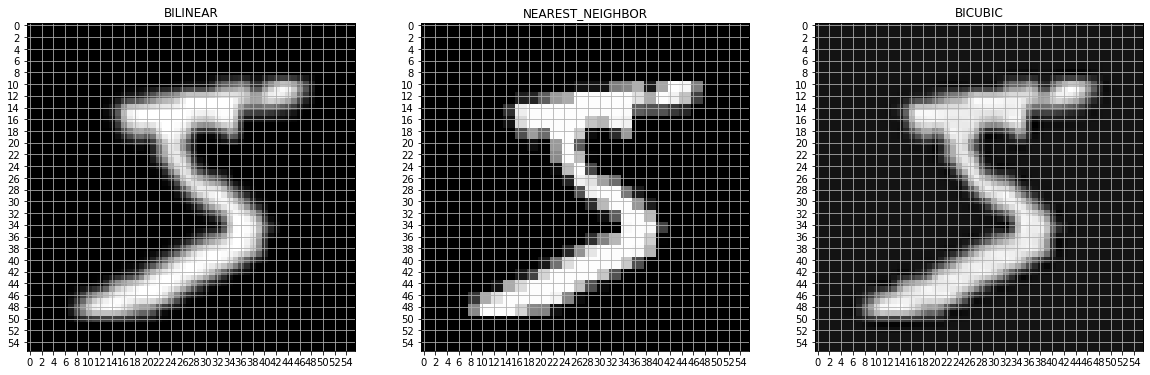

In [ ]:
def upsampling(scale, method):
  n = 28*scale
  img = tf.image.resize(x_train[0], [n, n], method=method, antialias=True)
  return tf.reshape(img, shape=(n, n))

image_bi = upsampling(2, tf.image.ResizeMethod.BILINEAR)
image_near = upsampling(2, tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image_cu = upsampling(2, tf.image.ResizeMethod.BICUBIC)
upsampled_images = np.stack([image_bi, image_near, image_cu])

titles = ['BILINEAR', 'NEAREST_NEIGHBOR', 'BICUBIC']
fig, axes = plt.subplots(1, len(titles), figsize=(20, 60))

for idx in range(len(titles)):
  axes[idx].imshow(upsampled_images[idx,...], cmap='gray')
  ticks = range(0,56,2)
  axes[idx].set_title(titles[idx])
  axes[idx].set_xticks(ticks)
  axes[idx].set_yticks(ticks)
  axes[idx].grid(which='both')

## 13.2.2 Conv2DTranspose

<img src="https://miro.medium.com/max/1400/1*kOThnLR8Fge_AJcHrkR3dg.gif" width=400 />


<convolution 연산의 특징> -> convolutional matrix

* positional connectivity 

* many-to-one relationship

--> 반대 연산을 만들 때 두 가지를 고려해야 함!


<img src="https://www.researchgate.net/publication/336144594/figure/fig2/AS:808881324322820@1569863744938/An-example-of-the-deconvolution-process-using-transpose-convolution-In-the-figure.png" width=400 />

<Transposed Convolution>

1. convolution 연산은 convolution matrix 를 이용해서 계산 가능

2. convolution matrix의 shape이 (n x m) 이면, transposed convolution matrix 는 (m x n) 

3. 4 x 4 이미지에 3 x 3 커널을 적용하면 2 x 2 출력이 나오며, 이때 convolution matrix는 4 x 16 이지만, 학습이 필요한 weights 는 9개 (커널)

4. 그러므로 transposed matrix 는 9 개의 weights 만으로 사용하자!

5. transposed matrix의 weights 값은 학습으로 찾음


<기술요소>

* backwards convolution operation

* Transposed convolution layer

* 더 정교한 방식의 업샘플링

In [ ]:
# tf.keras.layers.Conv2DTranspose
# Transposed convolution layer

# tf.keras.layers.Conv2DTranspose(
#     filters,
#     kernel_size,
#     strides=(1, 1),
#     padding='valid',
#     output_padding=None,
#     data_format=None,
#     dilation_rate=(1, 1),
#     activation=None,
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     bias_initializer='zeros',
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     **kwargs
# )

* 2배로 이미지를 키울 때: padding='same', strides=(2, 2)

In [ ]:
import tensorflow as tf
import numpy as np

#1: 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

#2: crate a 2D input data
A = np.array([[1, 2],
              [3, 4 ]],dtype='float32')
A = A.reshape(-1, 2, 2, 1)

#3: kernel
W = np.array([[ 1,  -1],      
               [ 2,  -2]], dtype = 'float32')
W = W.reshape(2, 2, 1, 1)   # (kernel_size[0], kernel_size[1], filters, channels)

#4: build a model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(A.shape[1:])) # shape = (2, 2, 1)
model.add(tf.keras.layers.Conv2DTranspose(filters=1,
                                 kernel_size = (2, 2),
                                 strides = (1, 1),
                                 padding = 'valid',  # 'same'
                                 use_bias = False,
                                 kernel_initializer = tf.constant_initializer(W)))
model.summary()
##model.set_weights([W]) # kernel_initializer = tf.constant_initializer(W)

#5: apply A to model
B = model.predict(A)     # (batch, new_rows, new_cols, filters)
print("B.shape=", B.shape)
print("B[0,:,:,0]=\n", B[0,:,:,0])

#6: weights
##W1 = model.get_weights() # W, model.trainable_variables
##print("W1[0].shape=", W1[0].shape)
##print("W1[0]=\n", W1[0])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 3, 3, 1)          4         
 nspose)                                                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 70ms/step
B.shape= (1, 3, 3, 1)
B[0,:,:,0]=
 [[ 1.  1. -2.]
 [ 5.  3. -8.]
 [ 6.  2. -8.]]


# 13.3 GAN

* GAN은 이미지 생성을 위한 CNN 과 같은 생성 모델을 훈련하기 위한 아키텍처

* GAN 은 Generator 와 Discriminator 모델로 구성됨 (둘 다 CNN 으로 구현)

**Generator**

* Generator 는 이미지의 features 를 채우는 것을 학습 

* Generator 는 출력 이미지를 생성하기 위해 입력 데이터를 업샘플링 함

**Discriminator**

* Discriminator 는 이미지가 진짜인지 가짜인지 판별

<img src="https://miro.medium.com/max/1276/0*Es2rdHsSZM4krQPw" width=400/>

<img src="https://www.tensorflow.org/tutorials/generative/images/gan2.png" width=400/>

<img src="https://i.imgur.com/0vuUsY0.png" width=800 />

## 13.3.1 Generator



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

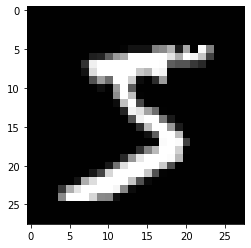

In [ ]:
# target sample - 숫자 5
real = (x_train[0]-255)/255.0
real
plt.figure()
plt.imshow(real, cmap='gray')

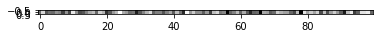

In [ ]:
#random noise
z = tf.random.normal(shape=(1, 100))
z
plt.figure()
plt.imshow(z, cmap='gray')

In [ ]:
def make_gan_generator_model():
  model = tf.keras.Sequential([
    #tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Dense(256, input_dim=100),
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(28*28*1, activation='sigmoid'),
    tf.keras.layers.Reshape((28, 28, 1))
    ])
  return model
G=make_gan_generator_model()
G.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 256)               25856     
                                                                 
 batch_normalization_11 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 re_lu_5 (ReLU)              (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 784)               201488    
                                                                 
 reshape_16 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 228,368
Trainable params: 227,856
Non-trainable params: 512
_____________________________________________

## 13.3.2 Discriminator

In [ ]:
def make_gan_discriminator_model():
  model=tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')])
  return model
D=make_gan_discriminator_model()
D.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_48 (Dense)            (None, 256)               200960    
                                                                 
 dense_49 (Dense)            (None, 1)                 257       
                                                                 
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
D_opt = tf.keras.optimizers.Adam(1e-4)
G_opt = tf.keras.optimizers.Adam(1e-4)

## 13.3.3 Loss function (Ian Goodfellow)


<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/fig3-Objective-function.png?ssl=1" width=800/>

<img src="https://drive.google.com/uc?id=1Xor4kf499aIX_iSkMSckQGU9QHmzpmi3" width="400"/><img src="https://drive.google.com/uc?id=1F7LcjDgtj1EuszHqh5zDOzNzBvC3sz8f" width="400"/>

Adversarial Machine Learning". ICLR Keynote, 2019


In [ ]:
def train_gan(epochs, z, real):
  fig, axs = plt.subplots(2, 5, figsize=(25, 10))
  fig.tight_layout()
  for i in range(epochs):
    with tf.GradientTape() as t1, tf.GradientTape() as t2:
      Z = D(G(z))   # to zero
      R = D(real)   # to one
            
      # max (real is 1, fake is zero)
      loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))  
      # max (generator wants to cheat D) 
      loss_G = -tf.reduce_mean(tf.math.log(Z))  

    D_grad = t1.gradient(loss_D, D.trainable_variables)
    D_opt.apply_gradients(zip(D_grad, D.trainable_variables))

    G_grad = t2.gradient(loss_G, G.trainable_variables)
    G_opt.apply_gradients(zip(G_grad, G.trainable_variables))

    # if i % 100 == 0:
    #   fake = G(z)
    #   fake = tf.reshape(fake, shape=(28, 28))
    #   print('fake', fake.shape)
    #   #plt.figure()
    #   idx=int(i/100)
    #   axes[idx].set_title("epochs: {}".format(i))
    #   axes[idx].imshow(fake, cmap='gray')    
    if i % 10 == 0:
      fake = G(z)
      fake = tf.reshape(fake, shape=(28, 28))
      row, col=int(i/50), int((i/10)%5)
      print('fake', row, col, fake.shape)
      axs[row, col].set_title("epochs: {}".format(i))
      axs[row, col].axis("off")
      axs[row, col].imshow(fake * 255.0, cmap='gray')   

(1, 100) (1, 28, 28, 1)
fake 0 0 (28, 28)
fake 0 1 (28, 28)
fake 0 2 (28, 28)
fake 0 3 (28, 28)
fake 0 4 (28, 28)
fake 1 0 (28, 28)
fake 1 1 (28, 28)
fake 1 2 (28, 28)
fake 1 3 (28, 28)
fake 1 4 (28, 28)


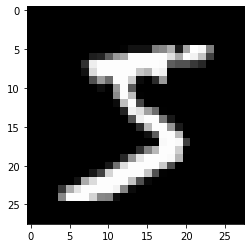

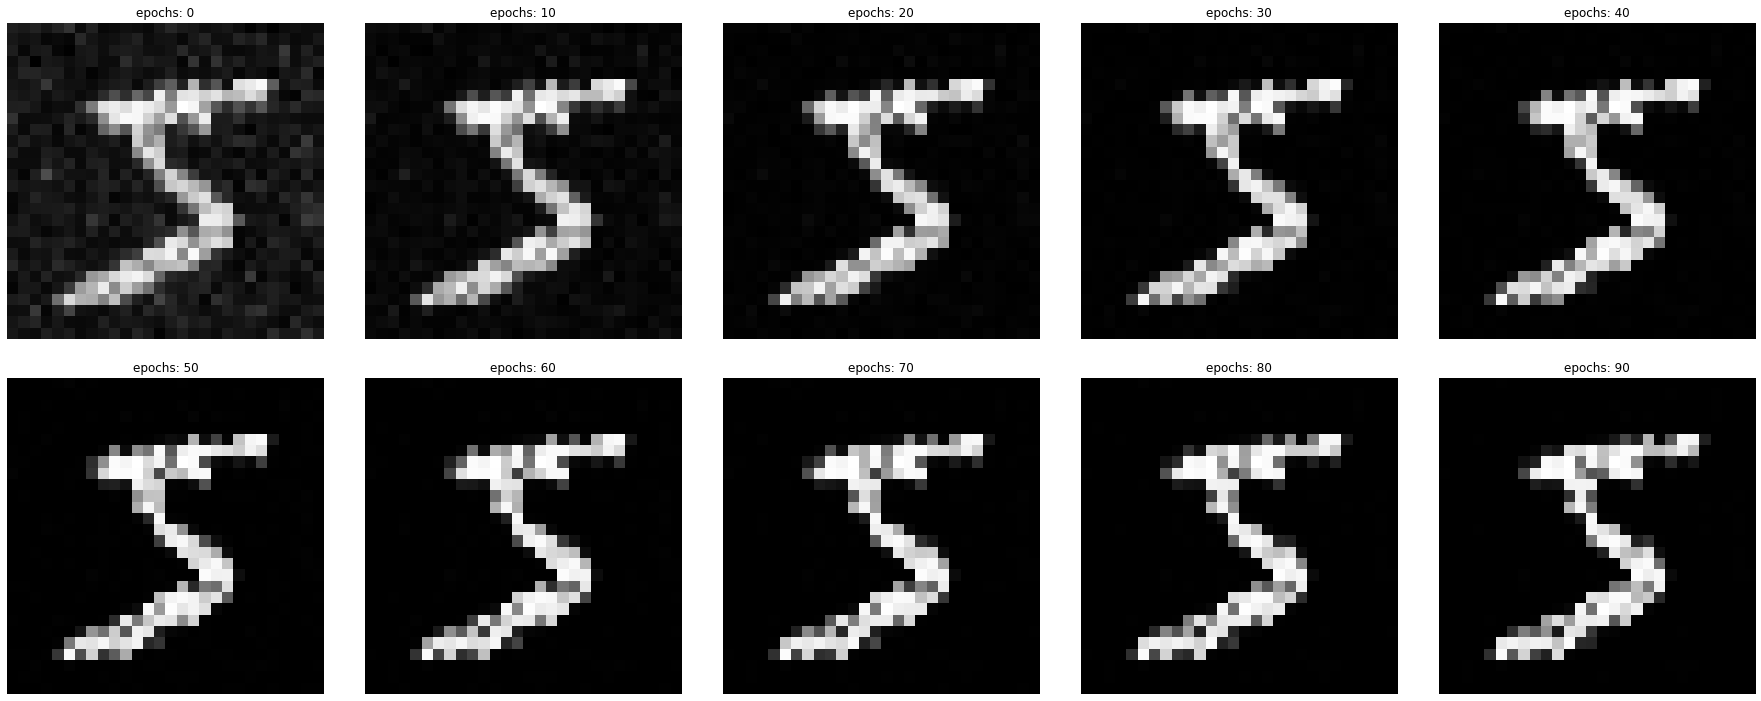

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# target sample - 숫자 5
real = x_train[0, ...]/255.0
#real
plt.figure()
plt.imshow(real, cmap='gray')
real=tf.reshape(real, shape=(1, 28, 28, 1))
#random noise
z = tf.random.normal(shape=(1, 100))
#z
#plt.figure()
#plt.imshow(z, cmap='gray')
print(z.shape, real.shape)
# 기도합시다 ㅠㅠ
train_gan(100, z, real)

## 13.3.3 Training GAN


In [ ]:
# def make_gan(G, D):
#   model=tf.keras.Sequential([
#       G,
#       D
#   ])
#   return model
# GAN=make_gan(G, D)
# GAN.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 28, 28, 1)         228368    
                                                                 
 sequential_22 (Sequential)  (None, 1)                 201217    
                                                                 
Total params: 429,585
Trainable params: 429,073
Non-trainable params: 512
_________________________________________________________________


In [ ]:
# D.compile(loss='binary_crossentropy',
#           optimizer='adam',
#           metrics=['accuracy'])
# D.trainable = False

# GAN.complie(loss='binary_crossentropy',
#             optimizer='adam')

In [ ]:
def make_gan_generator_model():
  model = tf.keras.Sequential([
    #tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Dense(256, use_bias=False, input_dim=100),
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(28*28*1, use_bias=False, activation='tanh'),   # (-1, 1)
    tf.keras.layers.Reshape((28, 28, 1))
    ])
  return model

def make_gan_discriminator_model():
  model=tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(256),
      # The model will be trained to output positive values for real images, 
      # and negative values for fake images.
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1)])
  return model

G=make_gan_generator_model()
D=make_gan_discriminator_model()

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

D_opt = tf.keras.optimizers.Adam(1e-4)
G_opt = tf.keras.optimizers.Adam(1e-4)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def make_dataset(batch_size):
  (x_train, y_train), (x_test_, y_test_) = tf.keras.datasets.mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
  x_train = (x_train) / 127.5 - 1
  train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
  return train_dataset

def train_step(batch_real_images):
  # input for G
  batch_z=tf.random.normal(shape=(batch_real_images.shape[0], 100))

  with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
    batch_fake_images = G(batch_z, training=True)

    real_output=D(batch_real_images, training=True)
    fake_output=D(batch_fake_images, training=True)

    d_loss=D_loss(real_output, fake_output)
    g_loss=G_loss(fake_output)

    d_gradients = d_tape.gradient(d_loss, D.trainable_variables)
    g_gradients = g_tape.gradient(g_loss, G.trainable_variables)

  D_opt.apply_gradients(zip(d_gradients, D.trainable_variables))
  G_opt.apply_gradients(zip(g_gradients, G.trainable_variables))


In [ ]:
def generate_images(epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = G(test_input, training=False)
  print('predictions', epoch, predictions.shape)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

predictions 1 (16, 28, 28, 1)
predictions 2 (16, 28, 28, 1)
predictions 3 (16, 28, 28, 1)
predictions 4 (16, 28, 28, 1)
predictions 5 (16, 28, 28, 1)
predictions 6 (16, 28, 28, 1)
predictions 7 (16, 28, 28, 1)
predictions 8 (16, 28, 28, 1)
predictions 9 (16, 28, 28, 1)
predictions 10 (16, 28, 28, 1)
predictions 11 (16, 28, 28, 1)
predictions 12 (16, 28, 28, 1)
predictions 13 (16, 28, 28, 1)
predictions 14 (16, 28, 28, 1)
predictions 15 (16, 28, 28, 1)
predictions 16 (16, 28, 28, 1)
predictions 17 (16, 28, 28, 1)
predictions 18 (16, 28, 28, 1)
predictions 19 (16, 28, 28, 1)
predictions 20 (16, 28, 28, 1)
predictions 21 (16, 28, 28, 1)


<ipython-input-112-126e4415d020>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4, 4))


predictions 22 (16, 28, 28, 1)
predictions 23 (16, 28, 28, 1)
predictions 24 (16, 28, 28, 1)
predictions 25 (16, 28, 28, 1)
predictions 26 (16, 28, 28, 1)
predictions 27 (16, 28, 28, 1)
predictions 28 (16, 28, 28, 1)
predictions 29 (16, 28, 28, 1)
predictions 30 (16, 28, 28, 1)
predictions 31 (16, 28, 28, 1)
predictions 32 (16, 28, 28, 1)
predictions 33 (16, 28, 28, 1)
predictions 34 (16, 28, 28, 1)
predictions 35 (16, 28, 28, 1)
predictions 36 (16, 28, 28, 1)
predictions 37 (16, 28, 28, 1)
predictions 38 (16, 28, 28, 1)
predictions 39 (16, 28, 28, 1)
predictions 40 (16, 28, 28, 1)
predictions 41 (16, 28, 28, 1)
predictions 42 (16, 28, 28, 1)
predictions 43 (16, 28, 28, 1)
predictions 44 (16, 28, 28, 1)
predictions 45 (16, 28, 28, 1)
predictions 46 (16, 28, 28, 1)
predictions 47 (16, 28, 28, 1)
predictions 48 (16, 28, 28, 1)
predictions 49 (16, 28, 28, 1)
predictions 50 (16, 28, 28, 1)


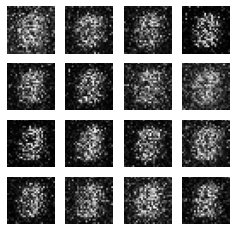

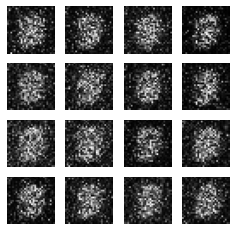

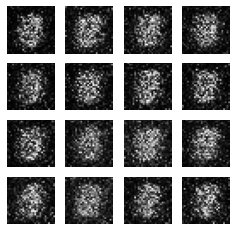

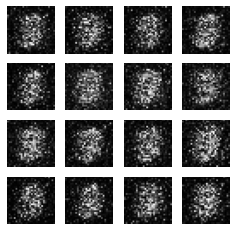

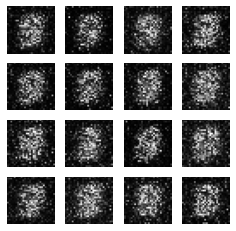

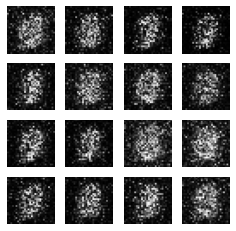

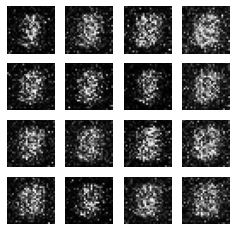

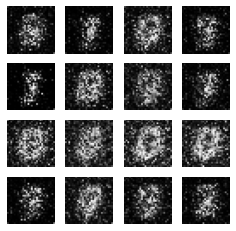

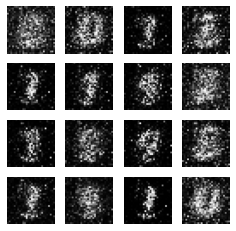

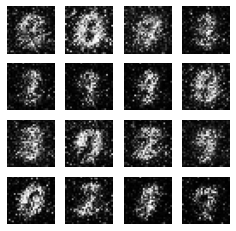

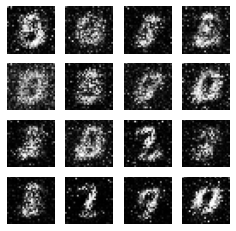

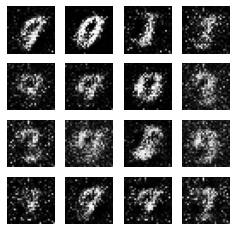

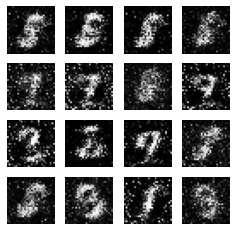

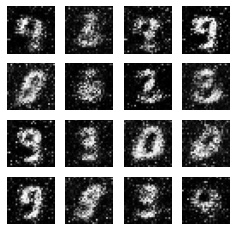

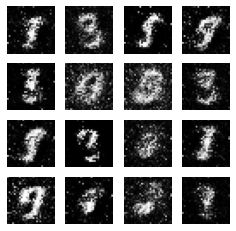

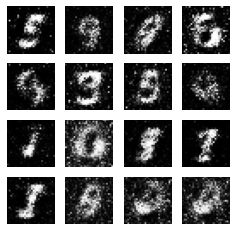

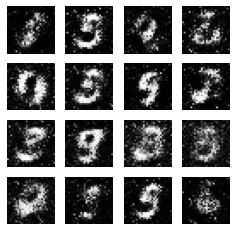

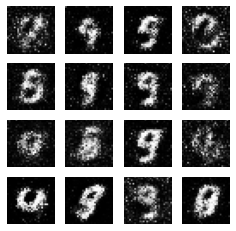

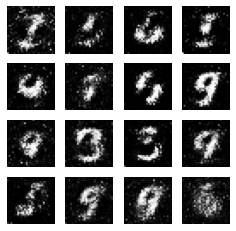

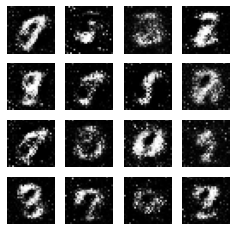

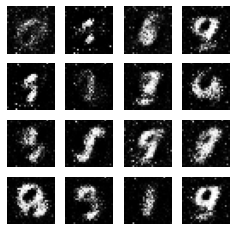

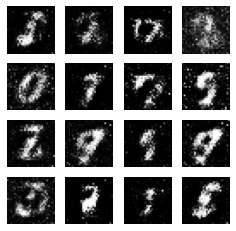

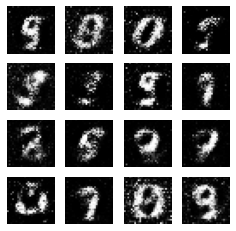

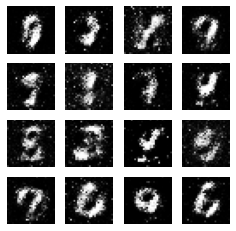

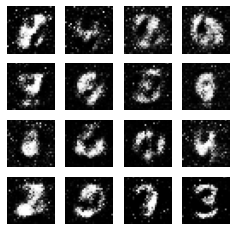

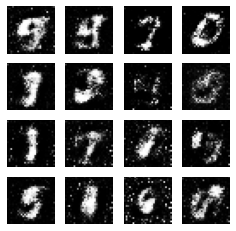

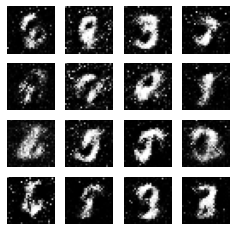

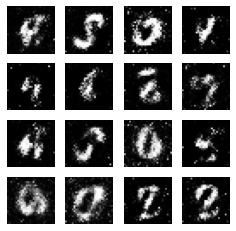

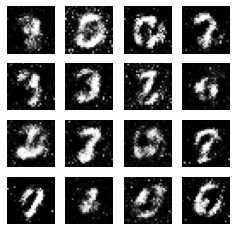

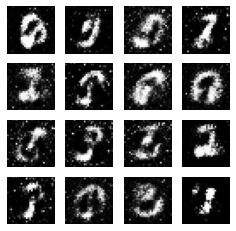

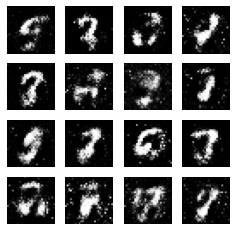

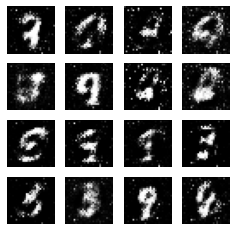

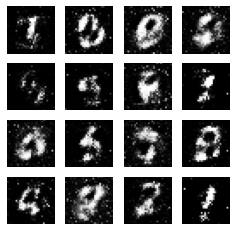

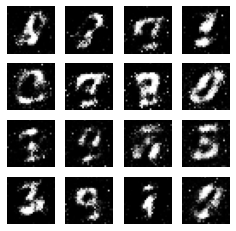

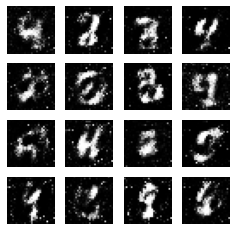

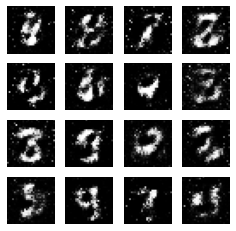

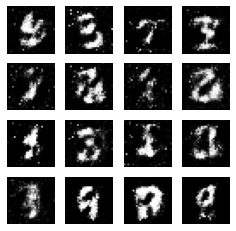

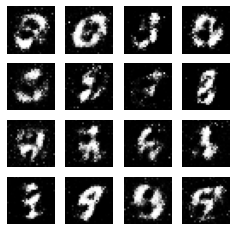

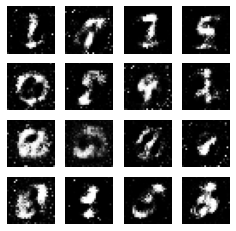

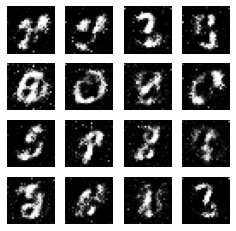

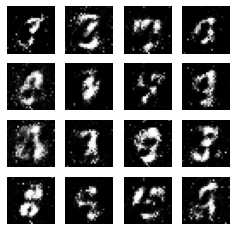

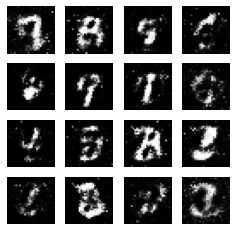

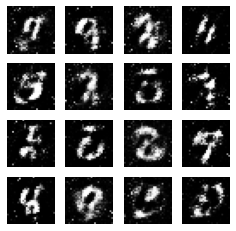

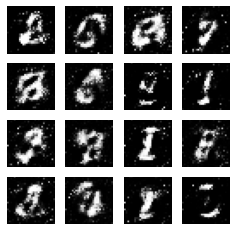

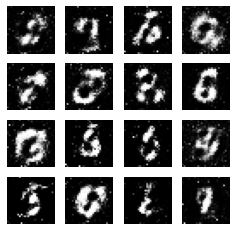

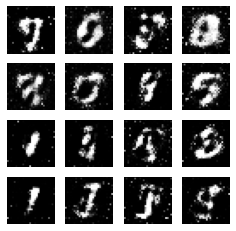

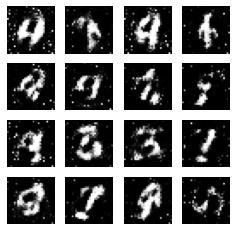

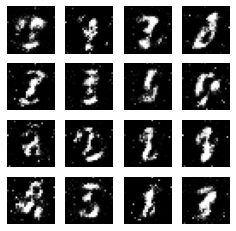

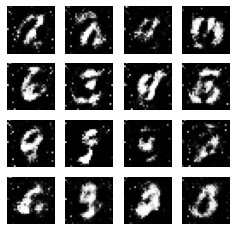

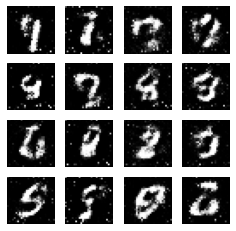

In [ ]:
epochs=50
batch_size=256
dataset=make_dataset(batch_size)

for epoch in range(epochs):
  for batch_real_images in dataset:
    train_step(batch_real_images)
  test_images=tf.random.normal(shape=(16, 100))
  generate_images(epoch+1, test_images)

# 13.4 DCGAN

# [tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

* pooling layer 를 모두 제거

-> convolution, transposed layer

* batchnorm layer 사용
* fully connected layer 제거
* generator 는 activation 으로 relu 사용, 마지막 레이어는 tanh 사용
* discriminator 는 reacky relu



In [ ]:
# 100x1 → 1024x4x4 → 512x8x8 → 256x16x16 → 128x32x32 → 64x64x3


## 13.4.1 Generator


<img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/11/6_DCGAN-G-architecture.jpg?lossy=1&strip=1&webp=1" width=800 />

* conv + max pooling -> 피처맵의 사이즈가 점점 작아짐 (downsampling)

* 반대로 할 수 있는가? 피처맵을 키워서 해상도 높은 피처를 만들어 보자! (upsampling)



Architecture guidelines for stable Deep Convolutional GANs

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.


[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)

In [ ]:
z=tf.random.normal(shape=(100, 1, 1))
z.shape

TensorShape([100, 1, 1])

In [ ]:
layer1 = tf.keras.layers.Dense(7*7*256, input_shape=(1, 1)) # 12544
x=layer1(z)
x.shape

TensorShape([100, 1, 12544])

In [ ]:
x=tf.reshape(x, [-1, 7, 7, 256])
x.shape

TensorShape([100, 7, 7, 256])

In [ ]:
x=tf.keras.layers.BatchNormalization()(x)
x.shape

TensorShape([100, 7, 7, 256])

In [ ]:
x=tf.keras.layers.ReLU()(x)
x.shape

TensorShape([100, 7, 7, 256])

In [ ]:
conv_layer1=tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), padding='same', strides=(2, 2), use_bias=False)
x=conv_layer1(x)
x.shape

TensorShape([100, 14, 14, 128])

In [ ]:
# [gamma weights, beta weights, moving_mean(non-trainable), moving_variance(non-trainable)]
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)
x.shape

TensorShape([100, 14, 14, 128])

In [ ]:
conv_layer2=tf.keras.layers.Conv2DTranspose(64, kernel_size=(4, 4), padding='same', strides=(2, 2), use_bias=False)
x=conv_layer2(x)
x.shape

TensorShape([100, 28, 28, 64])

In [ ]:
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)
x.shape

TensorShape([100, 28, 28, 64])

In [ ]:
conv_layer3=tf.keras.layers.Conv2DTranspose(1, kernel_size=(4, 4), padding='same', strides=(1, 1), use_bias=False, activation='tanh')
x=conv_layer3(x)
x.shape

TensorShape([100, 28, 28, 1])

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  #model.add(layers.BatchNormalization()) # for test using one sample
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), 
                                   padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 128)
  #model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), 
                                   padding='same', use_bias=False))
  assert model.output_shape == (None, 28, 28, 64)
  #model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), 
                                   padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

G=make_generator_model()
G.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819200    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       204800    
 ranspose)                                              

## 13.4.2 Discriminator

<img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/11/8_DCGAN-D-architecture.jpg?lossy=1&strip=1&webp=1" width=800 />

TensorShape([1, 28, 28, 1])

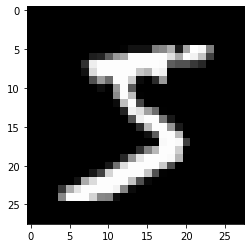

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
real = x_train[0,...]
plt.figure()
plt.imshow(real, cmap='gray')
real = tf.expand_dims(x_train[0,...], axis=2)
real = tf.expand_dims(real, axis=0)
real.shape

In [ ]:
z=tf.random.normal(shape=(1, 100))
fake = G(z)
fake.shape

TensorShape([1, 28, 28, 1])

In [ ]:
d_conv_layer=tf.keras.layers.Conv2D(64, kernel_size=(4, 4), padding='same', strides=(2,2), use_bias=False)
x=d_conv_layer(fake)
x.shape

TensorShape([1, 14, 14, 64])

In [ ]:
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)
x.shape

TensorShape([1, 14, 14, 64])

In [ ]:
d_conv_layer2=tf.keras.layers.Conv2D(128, kernel_size=(4, 4), padding='same', strides=(2,2), use_bias=False)
x=d_conv_layer2(x)
x.shape

TensorShape([1, 7, 7, 128])

In [ ]:
d_flatten_layer=tf.keras.layers.Flatten()
x=d_flatten_layer(x) # 7 x 7 x 128
x.shape

TensorShape([1, 6272])

In [ ]:
d_dense_layer=tf.keras.layers.Dense(1, activation='sigmoid')
x=d_dense_layer(x)
x.shape

TensorShape([1, 1])

In [ ]:
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    #model.add(layers.BatchNormalization()) # mode collapse
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

D=make_discriminator_model()
D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 138,561
Trainable params: 138,561
Non-tr

## 13.4.3 DCGAN Test

In [ ]:
G=make_generator_model()
D=make_discriminator_model()
D_opt = tf.keras.optimizers.Adam(1e-4)
G_opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def train_gan(epochs, z, real):
  fig, axs = plt.subplots(4, 5, figsize=(25, 20))
  fig.tight_layout()
  for i in range(epochs):
    with tf.GradientTape() as t1, tf.GradientTape() as t2:
      Z = D(G(z))   # to zero
      R = D(real)   # to one
            
      # max (real is 1, fake is zero)
      loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))  
      # max (generator wants to cheat D) 
      loss_G = -tf.reduce_mean(tf.math.log(Z))  

    D_grad = t1.gradient(loss_D, D.trainable_variables)
    D_opt.apply_gradients(zip(D_grad, D.trainable_variables))

    G_grad = t2.gradient(loss_G, G.trainable_variables)
    G_opt.apply_gradients(zip(G_grad, G.trainable_variables))

    # if i % 10 == 0:
    #   fake = G(z)
    #   fake = tf.reshape(fake, shape=(28, 28))
    #   print('fake', fake.shape)
    #   fig=plt.figure()
    #   fig.suptitle("epochs: {}".format(i))
    #   plt.imshow(fake, cmap='gray')   
      #idx=int(i/100)
      #axes[idx].set_title("epochs: {}".format(i))
      #axes[idx].imshow(fake, cmap='gray')    

    if i % 10 == 0:
      fake = G(z)
      fake = tf.reshape(fake, shape=(28, 28))
      row, col=int(i/50), int((i/10)%5)
      print('fake', row, col, fake.shape)
      axs[row, col].set_title("epochs: {}".format(i))
      axs[row, col].axis("off")
      axs[row, col].imshow(fake * 127.5 + 127.5, cmap='gray')   
   

fake 0 0 (28, 28)
fake 0 1 (28, 28)
fake 0 2 (28, 28)
fake 0 3 (28, 28)
fake 0 4 (28, 28)
fake 1 0 (28, 28)
fake 1 1 (28, 28)
fake 1 2 (28, 28)
fake 1 3 (28, 28)
fake 1 4 (28, 28)
fake 2 0 (28, 28)
fake 2 1 (28, 28)
fake 2 2 (28, 28)
fake 2 3 (28, 28)
fake 2 4 (28, 28)
fake 3 0 (28, 28)
fake 3 1 (28, 28)
fake 3 2 (28, 28)
fake 3 3 (28, 28)
fake 3 4 (28, 28)


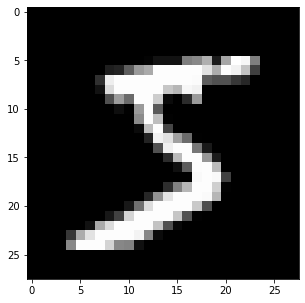

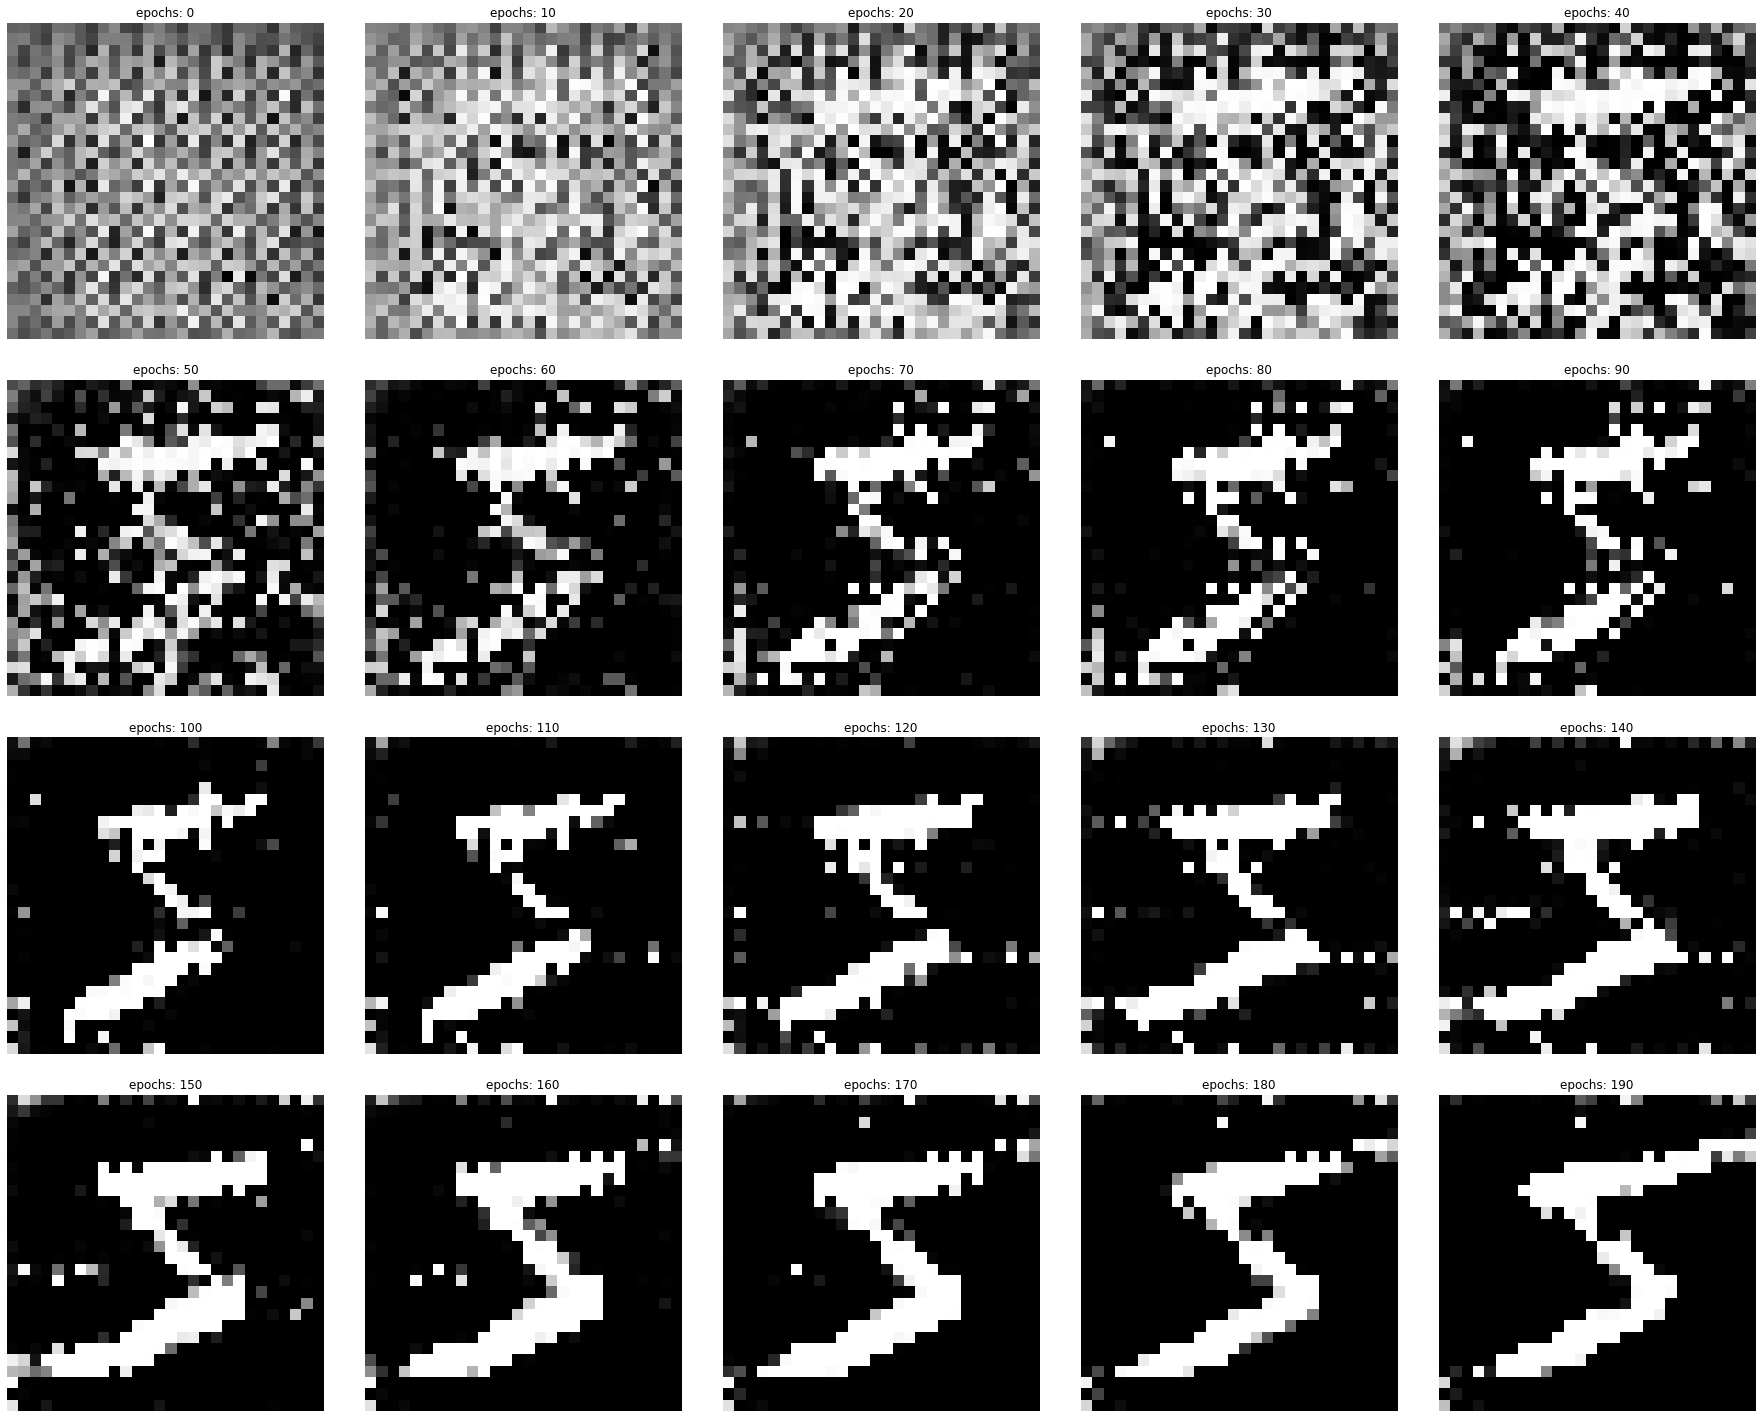

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
real = x_train[0,...]/127.5 - 1
plt.figure(figsize=(5,5))
plt.imshow(real, cmap='gray')
real = tf.reshape(real, shape=(1, 28, 28, 1))
#real = tf.expand_dims(x_train[0,...], axis=2)
#real = tf.expand_dims(real, axis=0)

z=tf.random.normal(shape=(1, 100))
#print(type(z), type(real))
train_gan(200, z, real)

## 13.4.4 Training DCGAN

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization()) # for test using one sample
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 28, 28, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    #model.add(layers.BatchNormalization()) # mode collapse
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

G=make_generator_model()
D=make_discriminator_model()

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

D_opt = tf.keras.optimizers.Adam(1e-4)
G_opt = tf.keras.optimizers.Adam(1e-4)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def make_dataset(batch_size):
  (x_train, y_train), (x_test_, y_test_) = tf.keras.datasets.mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
  x_train = (x_train) / 127.5 - 1
  train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
  return train_dataset

def train_step(batch_real_images):
  # input for G
  batch_z=tf.random.normal(shape=(batch_real_images.shape[0], 100))

  with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
    batch_fake_images = G(batch_z, training=True)

    real_output=D(batch_real_images, training=True)
    fake_output=D(batch_fake_images, training=True)

    d_loss=D_loss(real_output, fake_output)
    g_loss=G_loss(fake_output)

    d_gradients = d_tape.gradient(d_loss, D.trainable_variables)
    g_gradients = g_tape.gradient(g_loss, G.trainable_variables)

  D_opt.apply_gradients(zip(d_gradients, D.trainable_variables))
  G_opt.apply_gradients(zip(g_gradients, G.trainable_variables))


In [ ]:
def generate_images(epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = G(test_input, training=False)
  print('predictions', epoch, predictions.shape)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

predictions 1 (16, 28, 28, 1)
predictions 2 (16, 28, 28, 1)
predictions 3 (16, 28, 28, 1)
predictions 4 (16, 28, 28, 1)
predictions 5 (16, 28, 28, 1)
predictions 6 (16, 28, 28, 1)
predictions 7 (16, 28, 28, 1)
predictions 8 (16, 28, 28, 1)
predictions 9 (16, 28, 28, 1)
predictions 10 (16, 28, 28, 1)
predictions 11 (16, 28, 28, 1)
predictions 12 (16, 28, 28, 1)
predictions 13 (16, 28, 28, 1)
predictions 14 (16, 28, 28, 1)
predictions 15 (16, 28, 28, 1)
predictions 16 (16, 28, 28, 1)
predictions 17 (16, 28, 28, 1)
predictions 18 (16, 28, 28, 1)
predictions 19 (16, 28, 28, 1)
predictions 20 (16, 28, 28, 1)
predictions 21 (16, 28, 28, 1)


<ipython-input-116-126e4415d020>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4, 4))


predictions 22 (16, 28, 28, 1)
predictions 23 (16, 28, 28, 1)
predictions 24 (16, 28, 28, 1)
predictions 25 (16, 28, 28, 1)
predictions 26 (16, 28, 28, 1)
predictions 27 (16, 28, 28, 1)
predictions 28 (16, 28, 28, 1)
predictions 29 (16, 28, 28, 1)
predictions 30 (16, 28, 28, 1)
predictions 31 (16, 28, 28, 1)
predictions 32 (16, 28, 28, 1)
predictions 33 (16, 28, 28, 1)
predictions 34 (16, 28, 28, 1)
predictions 35 (16, 28, 28, 1)
predictions 36 (16, 28, 28, 1)
predictions 37 (16, 28, 28, 1)
predictions 38 (16, 28, 28, 1)
predictions 39 (16, 28, 28, 1)
predictions 40 (16, 28, 28, 1)
predictions 41 (16, 28, 28, 1)
predictions 42 (16, 28, 28, 1)
predictions 43 (16, 28, 28, 1)
predictions 44 (16, 28, 28, 1)
predictions 45 (16, 28, 28, 1)
predictions 46 (16, 28, 28, 1)
predictions 47 (16, 28, 28, 1)
predictions 48 (16, 28, 28, 1)
predictions 49 (16, 28, 28, 1)
predictions 50 (16, 28, 28, 1)


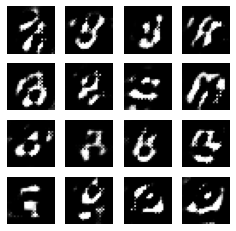

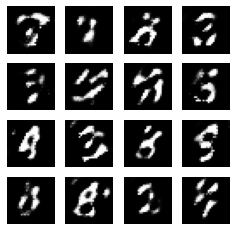

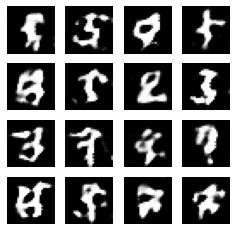

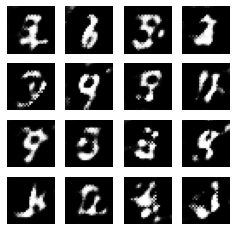

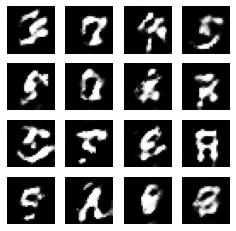

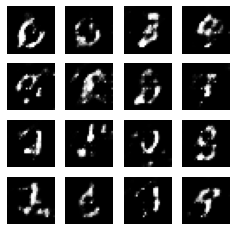

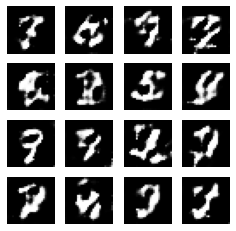

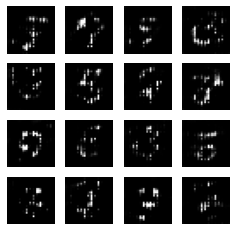

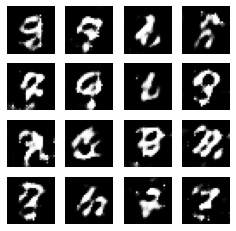

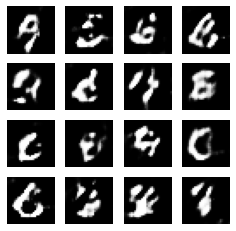

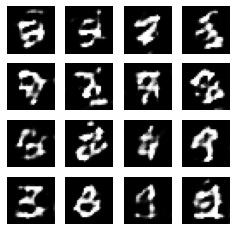

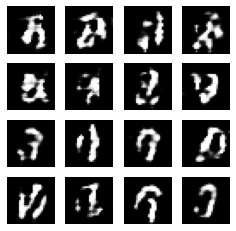

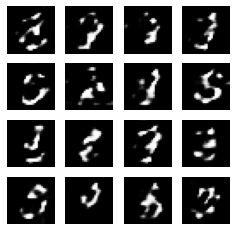

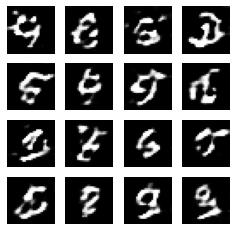

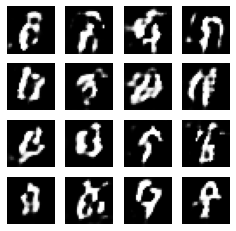

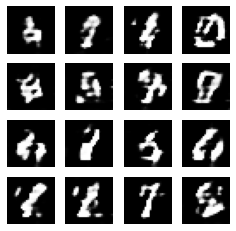

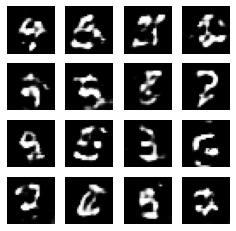

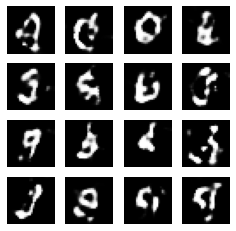

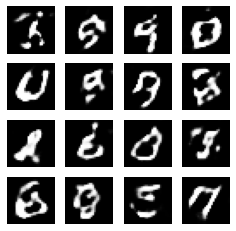

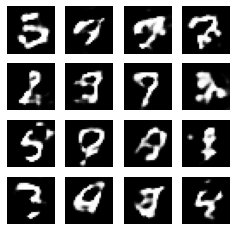

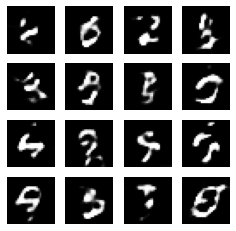

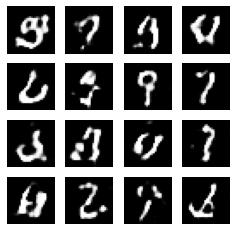

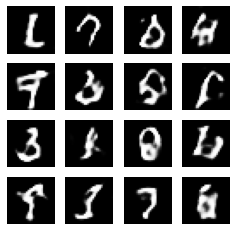

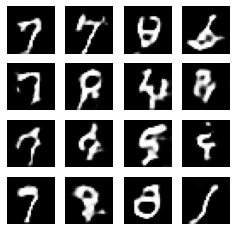

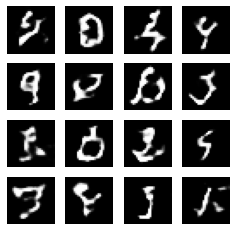

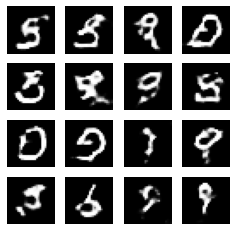

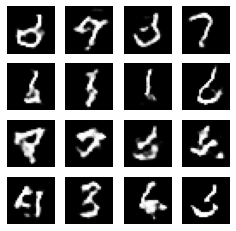

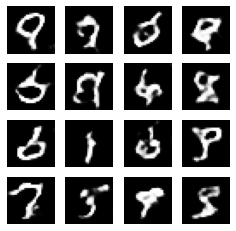

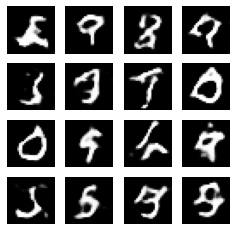

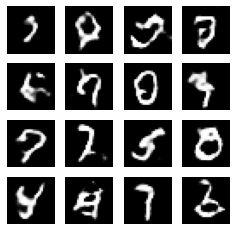

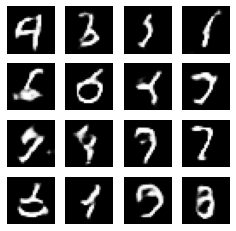

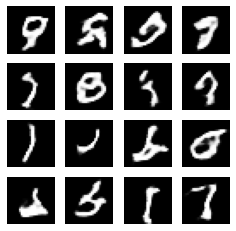

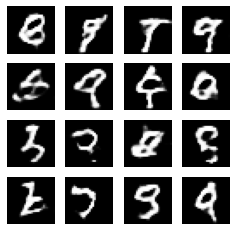

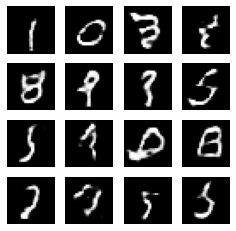

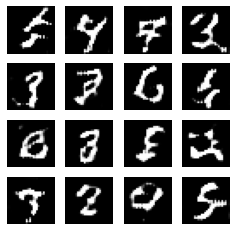

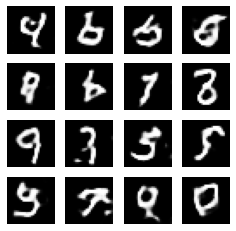

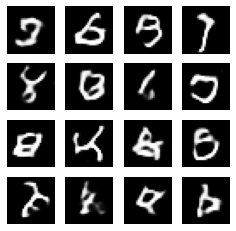

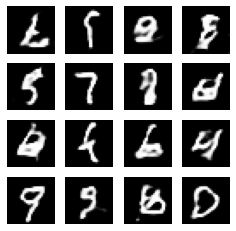

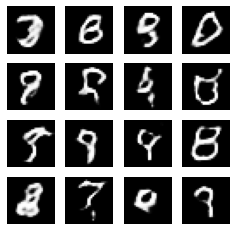

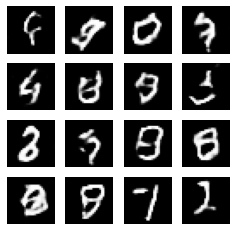

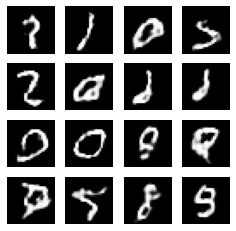

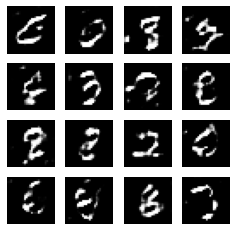

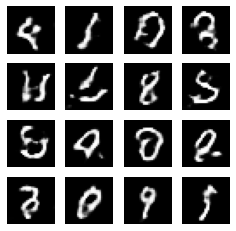

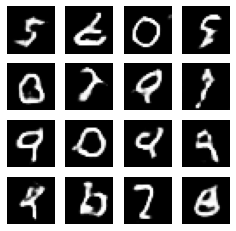

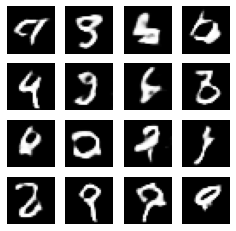

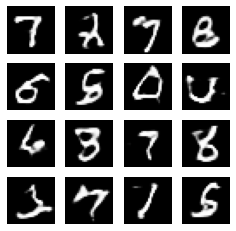

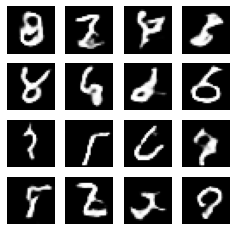

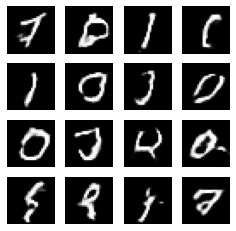

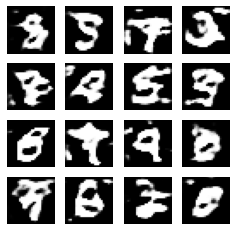

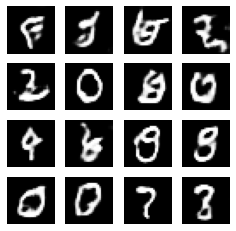

In [ ]:
epochs=50
batch_size=256
dataset=make_dataset(batch_size)

for epoch in range(epochs):
  for batch_real_images in dataset:
    train_step(batch_real_images)
  test_images=tf.random.normal(shape=(16, 100))
  generate_images(epoch+1, test_images)